<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/Gaussian_Mixture_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder


In [ ]:
seed = 0

In [ ]:

def print_metrics(X, true_labels_values, predicted_labels):
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")


## Gaussian Mixture Model

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import pdb

def initialize_parameters(X, k, init_means):
    n, d = X.shape

    if init_means is not None:
        means = init_means.copy()
    else:
        means = X[np.random.choice(n, k, replace=False)]
    covariances = [np.eye(d) for _ in range(k)]
    mixing_coeffs = np.ones(k) / k

    return means, covariances, mixing_coeffs

def compute_responsibilities(X, means, covariances, mixing_coeffs):
    n = X.shape[0]
    k = len(means)
    responsibilities = np.zeros((n, k))
    responsibilities = responsibilities + 1e-10 * np.ones_like(responsibilities) # trying smoothing
    if(np.any(np.isnan(responsibilities))):
        pdb.set_trace()
        print("responsibilities nan")
        print(responsibilities)
        print(mixing_coeffs)

    for j in range(k):
        responsibilities[:, j] = mixing_coeffs[j] * multivariate_normal.pdf(X, mean=means[j], cov=covariances[j], allow_singular=True)

    responsibilities = responsibilities + 1e-10 * np.ones_like(responsibilities)

    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    return responsibilities

def update_parameters(X, responsibilities):
    n, d = X.shape
    k = responsibilities.shape[1]

    N = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, X) / N[:, np.newaxis]

    covariances = []
    for j in range(k):
        diff = X - means[j]
        covariances.append(np.dot(responsibilities[:, j] * diff.T, diff) / N[j])

    mixing_coeffs = N / n

    if(np.any(np.isnan(means))):
      pdb.set_trace()
      print("means nan")
      print(responsibilities)
      print(X)

    return means, covariances, mixing_coeffs

def compute_log_likelihood(X, means, covariances, mixing_coeffs):
    n = X.shape[0]
    k = len(means)
    log_likelihood = 0

    for i in range(n):
        likelihood = 0
        for j in range(k):
            if(np.any(np.isnan(means))):
              pdb.set_trace()
              print("means nan")
              print(means)
            elif(np.any(np.isnan(covariances))):
              pdb.set_trace()
              print("covariances nan")
              print(covariances)
            elif(np.any(np.isnan(mixing_coeffs))):
              pdb.set_trace()
              print("mixing_coeffs nan")
              print(mixing_coeffs)
            elif(np.all(np.isfinite(means)) == False):
              pdb.set_trace()
              print("means inf")
              print(means)
            elif(np.all(np.isfinite(covariances)) == False):
              pdb.set_trace()
              print("covariances inf")
              print(covariances)
            elif(np.all(np.isfinite(mixing_coeffs)) == False):
              pdb.set_trace()
              print("mixing_coeffs inf")
              print(mixing_coeffs)

            likelihood += mixing_coeffs[j] * multivariate_normal.pdf(X[i], mean=means[j], cov=covariances[j], allow_singular = True)
        log_likelihood += np.log(likelihood)

    return log_likelihood

def gmm_em(X, k, epsilon=1e-6, max_iterations=100, means=None):
    means, covariances, mixing_coeffs = initialize_parameters(X, k, init_means=means)
    prev_log_likelihood = -np.inf

    for iteration in range(max_iterations):
        responsibilities = compute_responsibilities(X, means, covariances, mixing_coeffs)
        means, covariances, mixing_coeffs = update_parameters(X, responsibilities)
        log_likelihood = compute_log_likelihood(X, means, covariances, mixing_coeffs)

        if np.abs(log_likelihood - prev_log_likelihood) < epsilon:
            break

        prev_log_likelihood = log_likelihood

    cluster_assignments = np.argmax(responsibilities, axis=1)
    return cluster_assignments, means, covariances, mixing_coeffs

# Example usage:
# X = np.array([...])  # Your data points
# k = 3  # Number of components
# assignments, means, covariances, mixing_coeffs = gmm_em(X, k)

In [ ]:

from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms
import copy


path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=4, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_
init_means_base = get_initial_means(X_iris, "kmeans", seed)
init_means_sklearn = copy.deepcopy(init_means_base)

print("Iris Dataset\n")

start_time = time.time()
# cluters, noise, labels_base_iris = dbscan_base(X_iris, 0.5, 5)
labels_base_iris, means, covariances, mixing_coeffs = gmm_em(X_iris, 4, means=init_means_base)
print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_iris, iris["species"], labels_base_iris)

start_time = time.time()
# dbscan_iris = DBSCAN().fit(X_iris)

# labels_sklearn_iris = dbscan_iris.labels_


gmm = GaussianMixture(
        n_components=4, means_init=init_means_sklearn, tol=1e-6, max_iter=100, random_state=seed
    ).fit(X_iris)

labels_sklearn_iris = gmm.predict(X_iris)

# colors = ["red", "green", "blue", "yellow"]

# for i, color in enumerate(colors):
#         data = X[gmm.predict(X) == i]
#         plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris["species"], labels_sklearn_iris)

Iris Dataset

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 3 3 0 0 0 0 0 0 0 3 0 0 3 3 3 0 3 0 3 3
 0 0 0 3 3 0 0 0 0 2 3 0 0 3 0 0 3 0 0 0 0 3 0 0 0 0 3 2 2 2 2 2 2 2 2 2 3
 3 3 2 2 3 2 2 2 2 3 2 2 3 2 2 3 3 2 2 2 2 2 3 2 2 3 2 3 3 3 3 2 2 3 3 3 3
 3 3]
Execution time (base): 5.703234434127808 seconds
-------------------------------------------------------------------
Silhouette score: 0.3277
Adjusted Rand score: 0.6749
Calinski-Harabasz score: 302.2971
Davies-Bouldin score: 1.3774
Mutual Information score: 0.9064
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 3 0 3 0 3 0 0 0 0 0 0 3 0 0 3 0 3 0 2 0
 3 3 3 3 0 0 0 0 0 2 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2]

Execution time (sklearn): 0.033349037170410156 seconds
----------------------------------------------------

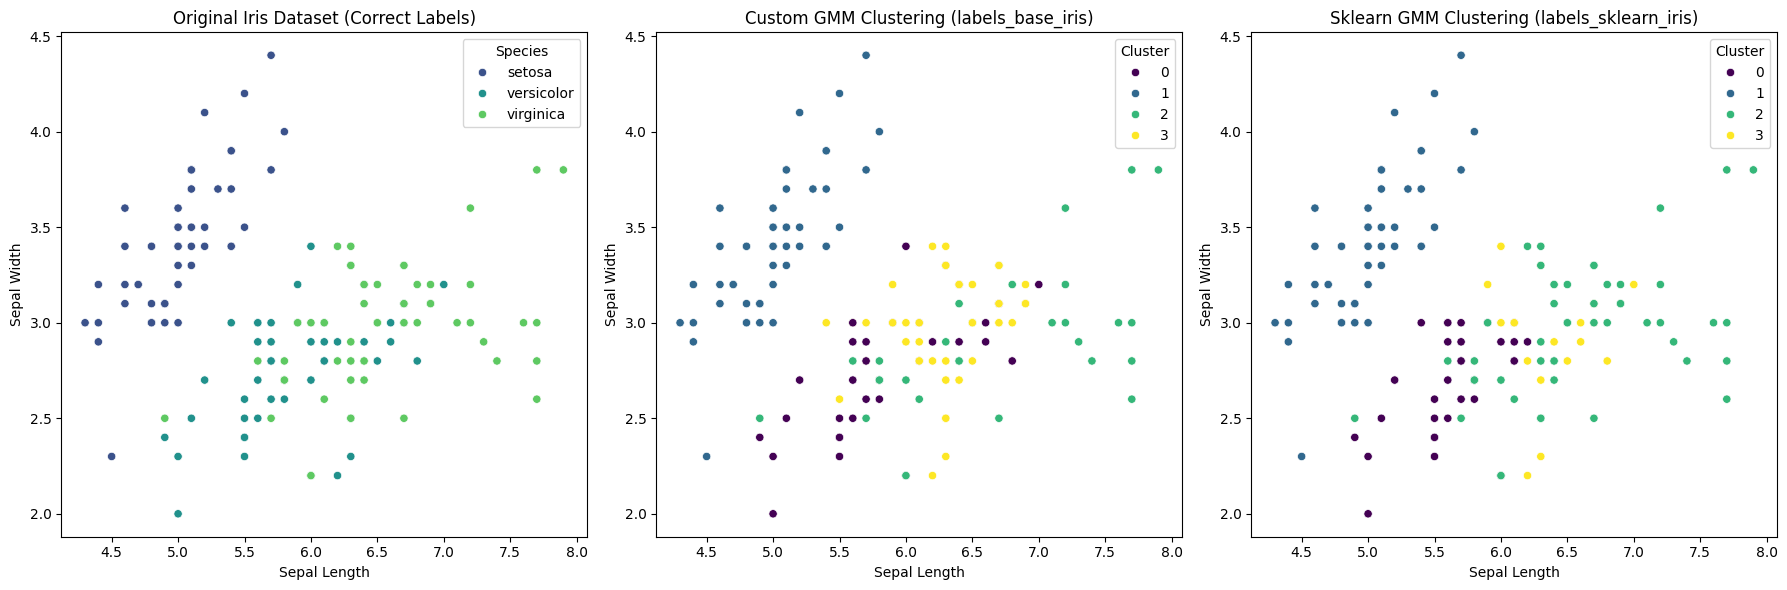

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom GMM Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[1])
axes[1].set_title("Custom GMM Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn GMM Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn GMM Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# AI Dataset

In [ ]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()
k_ai = 3

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

init_means_base = GaussianMixture(
        n_components=k_ai, init_params="kmeans", tol=1e-9, max_iter=0, random_state=seed
    ).fit(X_ai).means_
init_means_sklearn = copy.deepcopy(init_means_base)

start_time = time.time()


labels_base_ai, means, covariances, mixing_coeffs = gmm_em(X_ai, k_ai, means=init_means_base)

print(labels_base_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_ai, ai["Total_score_Category"], labels_base_ai)

start_time = time.time()
# kmeans_ai = KMeans(n_clusters=k_ai, random_state=seed).fit(X_ai)
# labels_sklearn_ai = kmeans_ai.labels_
# centroids_sklearn_ai = kmeans_ai.cluster_centers_


gmm = GaussianMixture(
        n_components=k_ai, means_init=init_means_sklearn, tol=1e-6, max_iter=100, random_state=seed
    ).fit(X_ai)

labels_sklearn_ai = gmm.predict(X_ai)

print(labels_sklearn_ai)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai["Total_score_Category"], labels_sklearn_ai)

100%|██████████| 2.38k/2.38k [00:00<00:00, 3.71MB/s]

Extracting files...
AI Global Index


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1]
Execution time (base): 0.5317552089691162 seconds
-------------------------------------------------------------------
Silhouette score: 0.2176
Adjusted Rand score: 0.4909
Calinski-Harabasz score: 18.5086
Davies-Bouldin score: 1.4243
Mutual Information score: 0.5961
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1]

Execution time (sklearn): 0.011106491088867188 seconds
-------------------------------------------------------------------
Silhouette score: 0.2169
Adjusted Rand score: 0.4577
Calinski-Harabasz score: 17.8797
Davies-Bouldin score: 1.4385
Mutual Information score: 0.5833


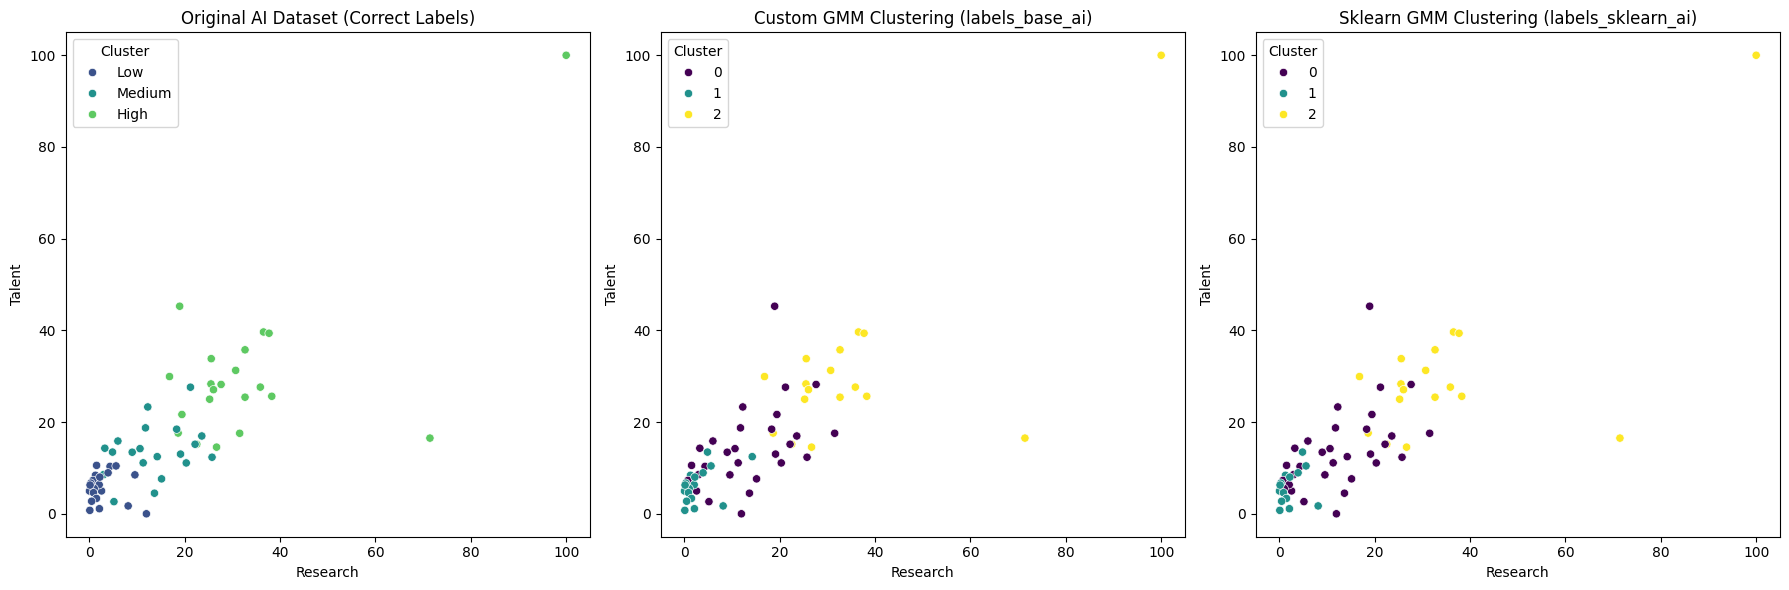

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom GMM Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn GMM Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:

path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()
k_earth = 4

print("Global Earthquake Data")

init_means_base = GaussianMixture(
        n_components=k_earth, init_params="kmeans", tol=1e-9, max_iter=0, random_state=seed
    ).fit(X_earth).means_
init_means_sklearn = copy.deepcopy(init_means_base)


start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)


labels_base_earth, means, covariances, mixing_coeffs = gmm_em(X_earth, k_earth, means = init_means_base)

print(labels_base_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_base_earth)

start_time = time.time()



gmm = GaussianMixture(
        n_components=k_earth, means_init=init_means_sklearn, tol=1e-6, max_iter=100, random_state=seed
    ).fit(X_earth)

labels_sklearn_earth = gmm.predict(X_earth)
print(labels_sklearn_earth)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_sklearn_earth)

100%|██████████| 214k/214k [00:00<00:00, 60.3MB/s]

Extracting files...
Global Earthquake Data


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

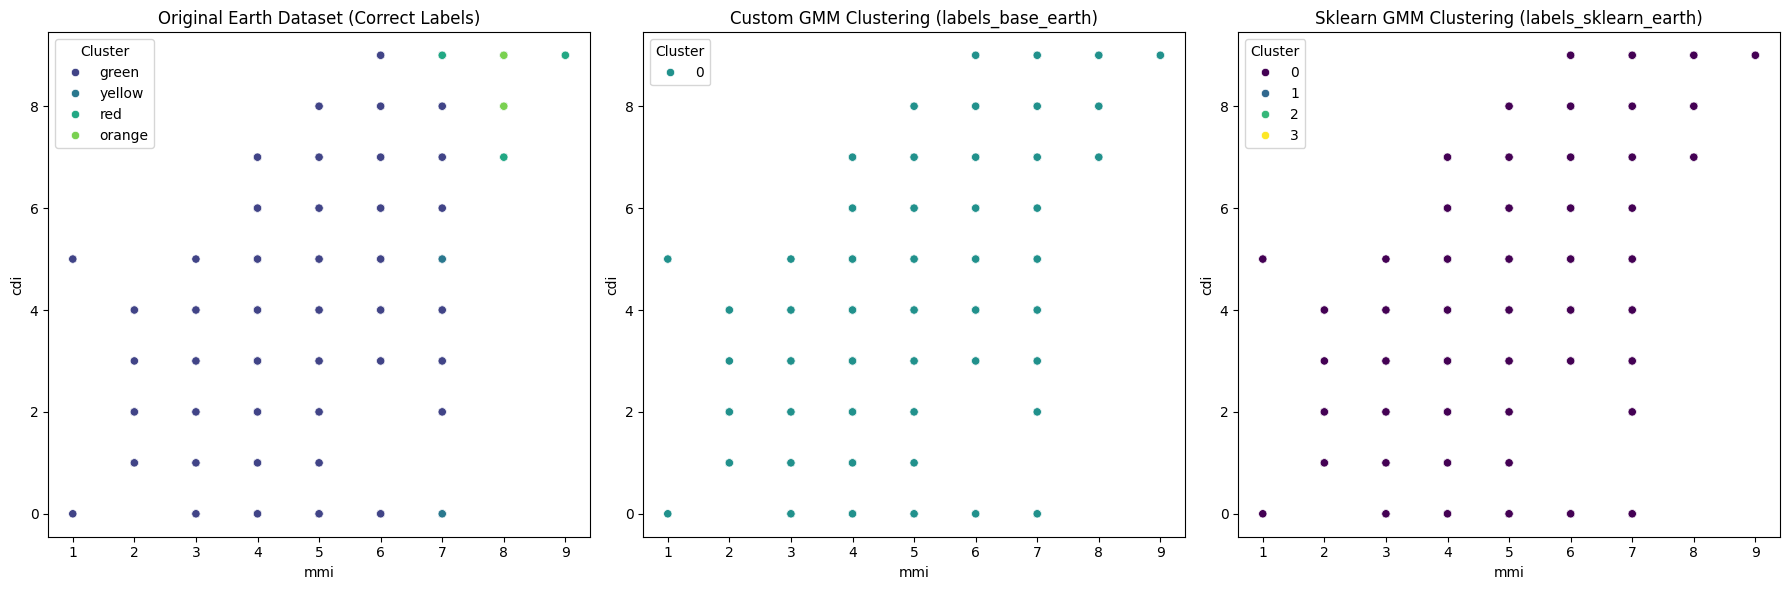

In [ ]:
# cdi_idx = list(earthquakes_filtered.columns).index("cdi")
# mmi_idx = list(earthquakes_filtered.columns).index("mmi")

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
# plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, cdi_idx], c='red', marker='x', s=150, label='Centroids (base)')
# plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, cdi_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

# plt.xlabel("mmi")
# plt.ylabel("cdi")
# plt.title("mmi vs. cdi in Global Earthquake dataset")
# plt.legend(title="Legend")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom GMM Clustering (labels_base_earth)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn GMM Clustering (labels_sklearn_earth)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

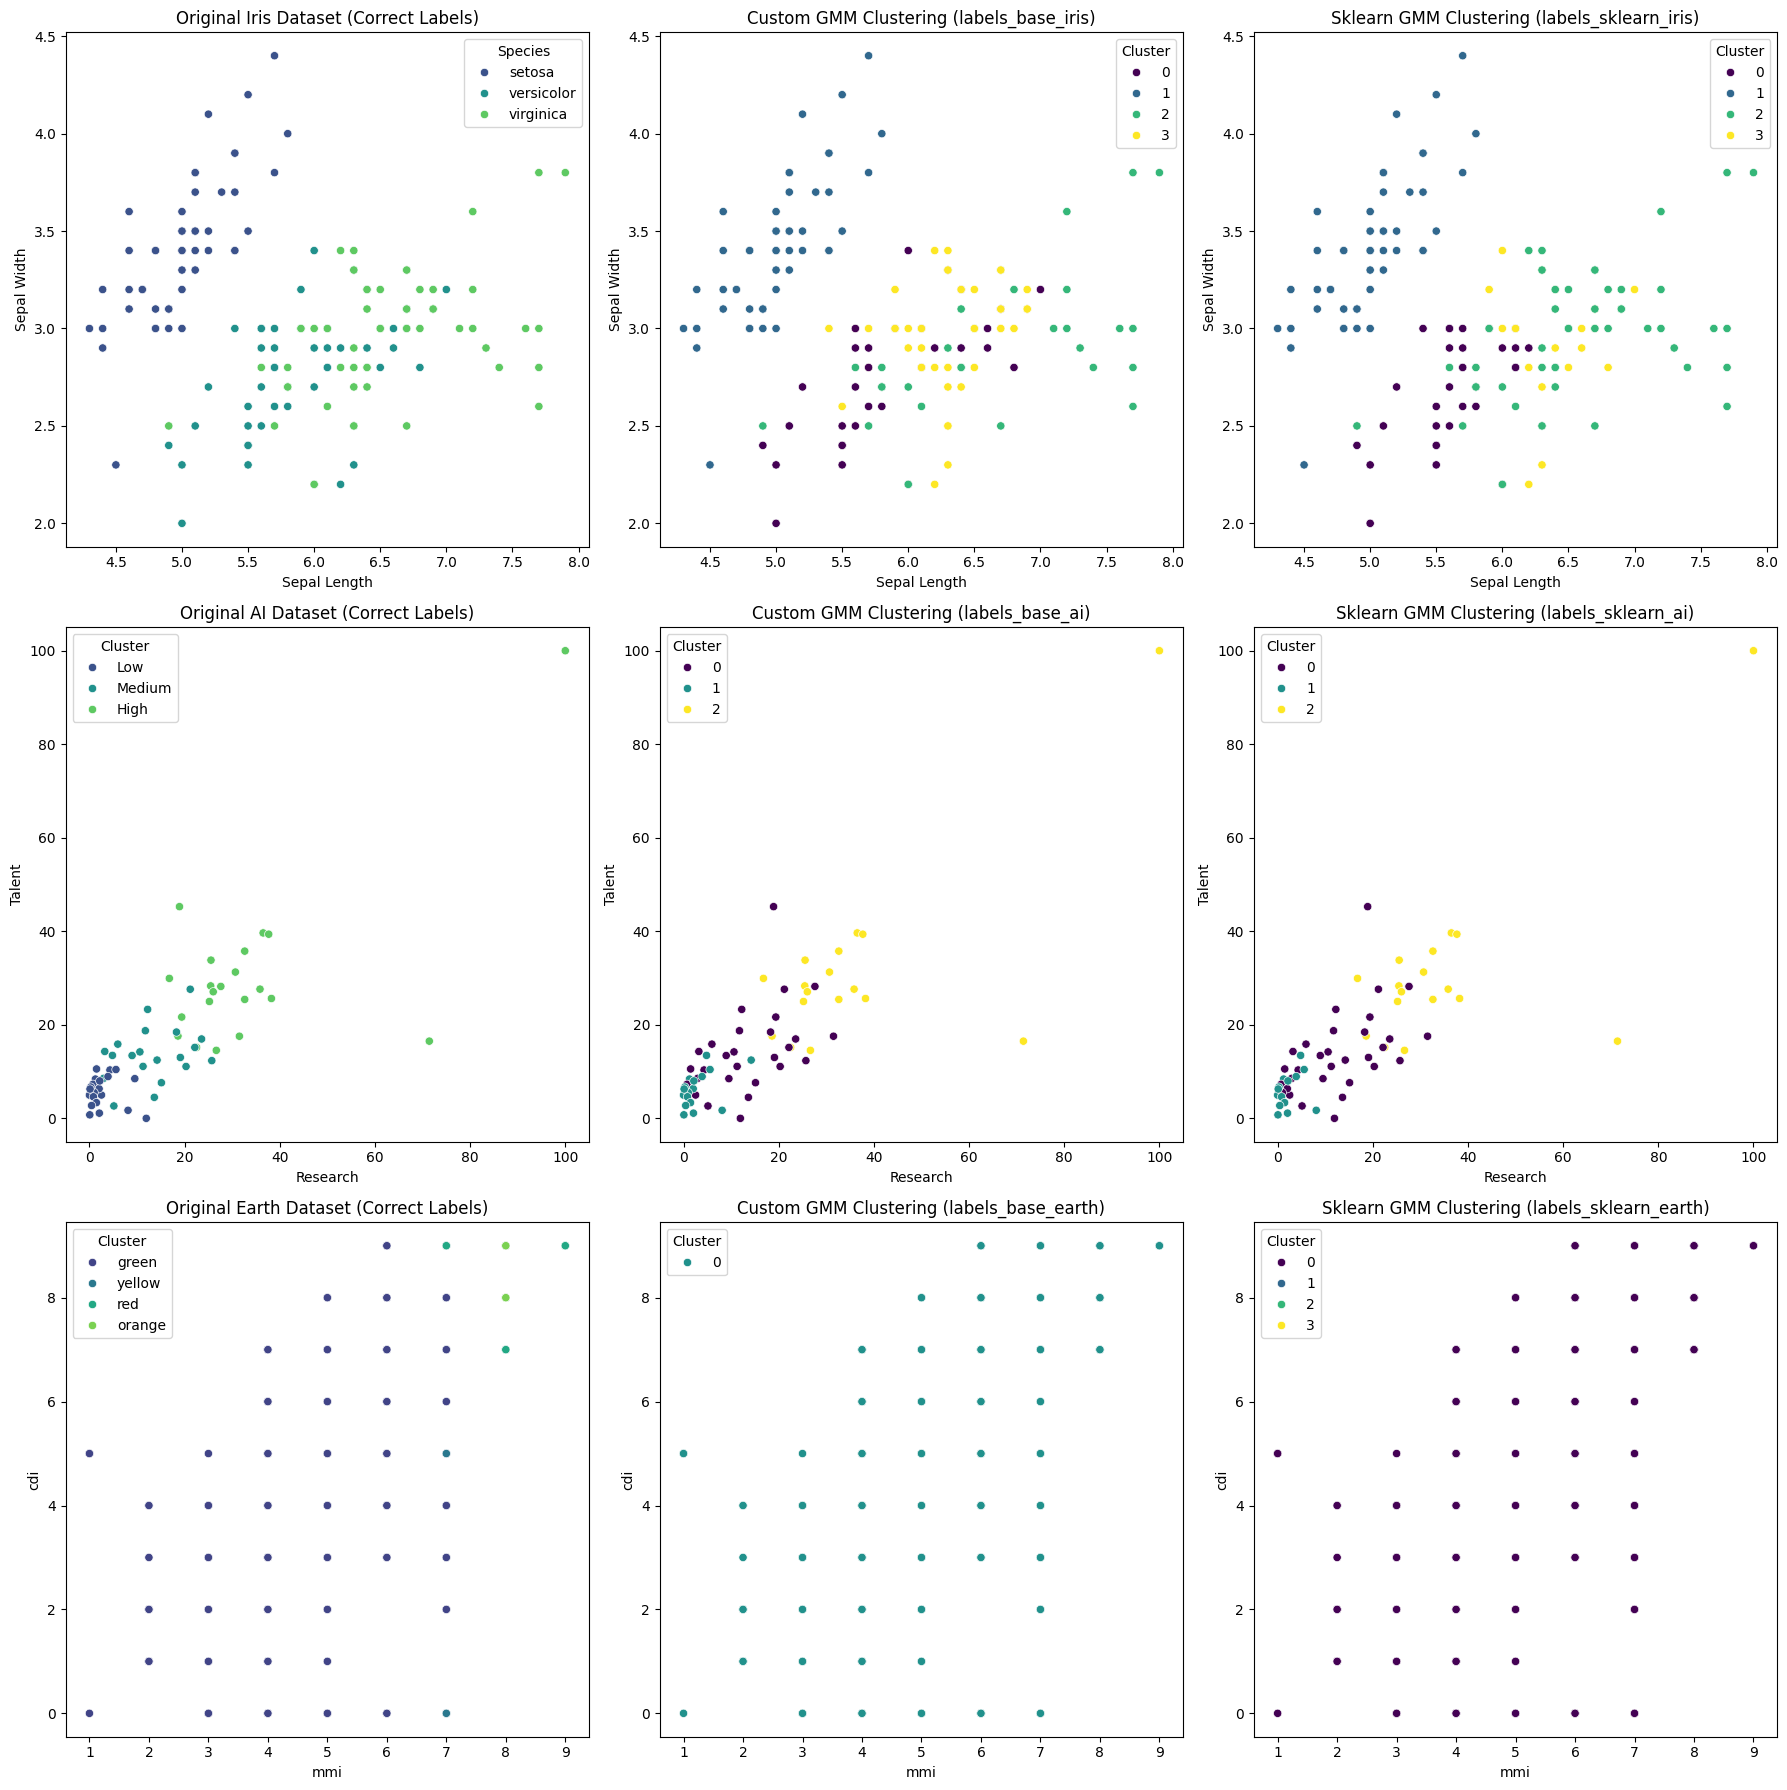

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("Sepal Length")
axes[0][0].set_ylabel("Sepal Width")
axes[0][0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[0][1])
axes[0][1].set_title("Custom GMM Clustering (labels_base_iris)")
axes[0][1].set_xlabel("Sepal Length")
axes[0][1].set_ylabel("Sepal Width")
axes[0][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[0][2])
axes[0][2].set_title("Sklearn GMM Clustering (labels_sklearn_iris)")
axes[0][2].set_xlabel("Sepal Length")
axes[0][2].set_ylabel("Sepal Width")
axes[0][2].legend(title="Cluster")

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset (Correct Labels)")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1][1])
axes[1][1].set_title("Custom GMM Clustering (labels_base_ai)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[1][2])
axes[1][2].set_title("Sklearn GMM Clustering (labels_sklearn_ai)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")


# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("cdi")
axes[2][0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[2][1])
axes[2][1].set_title("Custom GMM Clustering (labels_base_earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("cdi")
axes[2][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2][2])
axes[2][2].set_title("Sklearn GMM Clustering (labels_sklearn_earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("cdi")
axes[2][2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()